# Geometric shape dataset generator

This notebook generates a geometric shape dataset. It consists of circles with varying rotation and triangles with varying rotation and size.
Each item is a 64 by 64 pixel image, generated by applying a Gaussian blur to an image with 7 times higher resolution.

In [1]:
import io
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from scipy.stats import norm

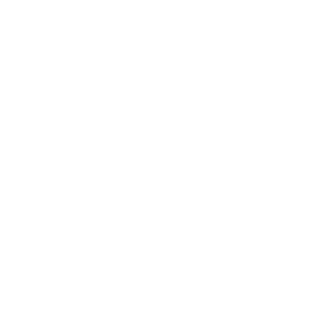

In [2]:
# Size of canvas
image_width = 64
image_height = 64
super_sampling_scale = 7
width = super_sampling_scale * image_width
height = super_sampling_scale * image_height

# Actual value of DPI does not matter for final output
# Larger value makes the matplotlib canvas smaller on screen
dpi = 100

# create a figure with fixed size
fig = plt.figure(frameon=False)
fig.set_size_inches(width/dpi, height/dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)

ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.patch.set_facecolor('blue')

io_buf = io.BytesIO()

In [3]:
def draw_shape(shape, x=.5*width, y=.5*height, bg_color=1, **kwargs):
    """
    Draw a shape on the matplotlib figure and return it as numpy array
    """
    # set background colour by adding a square patch
    bg_patch = ax.add_patch(patches.Rectangle((0, 0), width, height, color=str(bg_color)))
    if shape == 'circle':
        patch = generate_circle(x, y, **kwargs)
    elif shape == 'triangle':
        patch = generate_triangle(x, y, **kwargs)
    else:
        raise ValueError(f"Invalid shape: {shape}")
    # keep reference to the patch connected to the axis so it can be removed later
    patch = ax.add_patch(patch)
    # extract data from image
    # taken from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    io_buf.seek(0)
    fig.savefig(io_buf, format='rgba', dpi=dpi)
    io_buf.seek(0)
    # load (flattened) image into numpy array, reshape, keep only one channel (R)
    img = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape(width, height, -1)[..., 0]

    # remove the patches from the axis
    patch.remove()
    bg_patch.remove()
    return img

def generate_circle(x, y, radius, color):
    """
    Generate a matplotlib circle patch
    """
    return patches.Circle((x, y), radius, fc=str(color), ec=None)

def generate_triangle(x, y, radius, angle, color):
    """
    Generate a matplotlib triangle patch
    """
    a = rot(angle).dot(np.array([0, radius]))
    b = rot(120).dot(a)
    c = rot(120).dot(b)
    m = np.array([x,y])
    return patches.Polygon([a+m, b+m, c+m], fc=str(color), ec=None, closed=True)
    
def rot(angle_deg):
    """
    2D rotation matrix for given angle in degrees
    """
    angle = np.deg2rad(angle_deg)
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

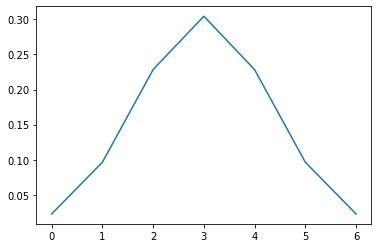

In [4]:
def get_smoothing_kernel(super_sampling_scale):
    """
    Gaussian smoothing kernel for given super-sampling scale
    """
    a = np.arange(super_sampling_scale).astype(float)
    a -= a.mean()
    a /= 0.66*a.std() 
    d = norm.pdf(a)
    d /= d.sum()
    return d

plt.plot(get_smoothing_kernel(7))

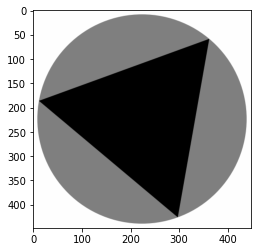

In [5]:
# Example triangle and circle at max radius
triangle = draw_shape('triangle', radius=.48*width, angle=40, color=.5)
circle = draw_shape('circle', radius=.48*width, color=.5)
data = circle + triangle

plt.figure()
plt.imshow(data, cmap='gray', vmin=0, vmax=255)

32it [00:00, 231.13it/s]
32it [00:00, 257.75it/s]


(64, 448, 448)
(64, 64, 64)


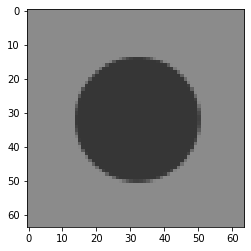

In [6]:
# Generate the circles and triangles
ncircle = 32
ntriangle = 32
shapes = np.empty(shape=(ncircle+ntriangle, height, width))

# circles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ncircle)
colors = np.random.uniform(0, 1, ncircle)
bg_colors = np.random.uniform(0, 1, ncircle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    shapes[n] = draw_shape('circle', radius=radius, color=colors[n], bg_color=bg_colors[n])

# triangles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ntriangle)
angles = np.random.uniform(0, 360, ntriangle)
colors = np.random.uniform(0, 1, ntriangle)
bg_colors = np.random.uniform(0, 1, ntriangle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    angle = angles[n]
    shapes[ncircle+n] = draw_shape('triangle', radius=radius, angle=angle, color=colors[n], bg_color=bg_colors[n])
    
# scale to 0-1
shapes = shapes.astype(float) / 255.
# apply Gaussian blur
for i,_ in enumerate(shapes):
    shapes[i] = cv2.GaussianBlur(shapes[i], (super_sampling_scale, super_sampling_scale), 0.3*super_sampling_scale,0)

# Extract subset of smoothed data to obtain target image size
print(shapes.shape)
shapes = shapes[:,::super_sampling_scale,::super_sampling_scale] # NB! This causes the circle to shift by less than 1 pixel, but the result is not exactly centered.
print(shapes.shape)
plt.imshow(shapes[0], cmap='gray', vmin=0, vmax=1)

In [7]:
# Labels for each item in the dataset, circle=0, triangle=1
classes = ['circle', 'triangle']
labels = np.zeros(ncircle+ntriangle, dtype=int)
# circle=0, triangle=1
labels[ncircle:] = 1

In [8]:
# put the data in random order
indices = np.random.choice(ncircle+ntriangle, size=ncircle+ntriangle, replace=False)
shapes = shapes[indices]
labels = labels[indices]

In [9]:
# store as compressed numpy array
np.savez_compressed('shapes.npz', X=shapes, y=labels)

In [10]:
!du -hs shapes.npz

144K	shapes.npz


In [11]:
# load data from disk
fd = np.load('shapes.npz')
X = fd['X']
y = fd['y']
fd.close()

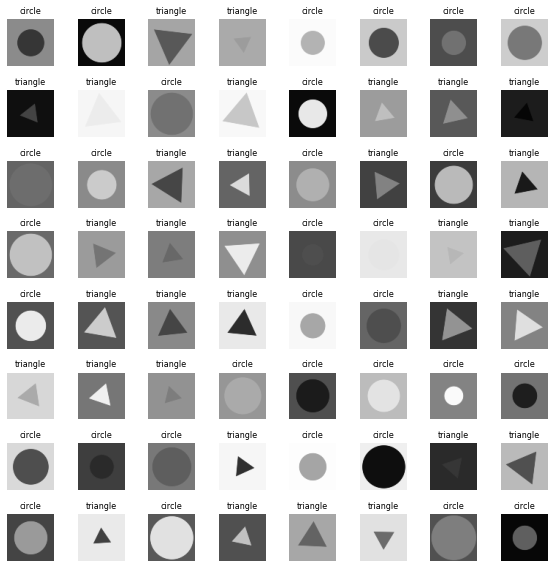

In [12]:
# Overview of the generated shapes
overview_fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
axes = axes.flatten()

for i in range(64):
    a = axes[i]
    a.imshow(X[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(classes[y[i]], fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()